# 1. data loading

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from google.colab import drive
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/listings_cols_removed.csv")
data

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (42) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,Clean & quiet apt home by the park,Renovated apt home in elevator building.<br />...,Close to Prospect Park and Historic Ditmas Park,2787,John,9/7/08,"New York, NY",Educated professional living in Brooklyn. I l...,within an hour,100%,...,5.00,4.75,4.88,NaN,f,9,1,6,2,0.11
1,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,2845,Jennifer,9/9/08,"New York, NY",A New Yorker since (Phone number hidden by Air...,within a day,75%,...,4.80,4.81,4.40,NaN,f,3,3,0,0,0.31
2,BlissArtsSpace!,One room available for rent in a 2 bedroom apt...,NaN,7356,Garon,2/3/09,"New York, NY","I am an artist(painter, filmmaker) and curato...",within an hour,100%,...,4.91,4.47,4.52,NaN,f,2,0,2,0,0.31
3,Beautiful Queens Brownstone! - 5BR,"<b>The space</b><br />Beautiful, fully furnish...",NaN,204539,Mark,8/17/10,"New York, NY",Father of two boys - 9 & 10.,within an hour,100%,...,5.00,4.82,4.55,NaN,f,6,6,0,0,0.10
4,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,NaN,7378,Rebecca,2/3/09,"New York, NY","Rebecca is an artist/designer, and Henoch is i...",NaN,NaN,...,5.00,4.67,5.00,NaN,f,1,1,0,0,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39876,Private Modern House by The Beach,Private modern house by the Beach with all com...,Rockaway Beach is a neighborhood that gives it...,23049030,Ramón,10/27/14,"New York, NY",NaN,within an hour,100%,...,5.00,4.94,4.88,NaN,f,1,1,0,0,1.22
39877,Beautiful apartment - minutes to NYC,Our apartment is straight across the river fro...,Our apartment is located in a very interesting...,48009648,Nathan,11/2/15,"New York, NY",NaN,within an hour,100%,...,4.96,4.81,4.85,NaN,f,1,1,0,0,2.12
39878,"1 Bedroom Basement, NEWLY Renovated",With easy access to multiple bus stops and the...,NaN,371552251,Sheraz,10/11/20,"Floral Park, NY",NaN,within an hour,100%,...,4.36,4.36,4.55,NaN,t,1,1,0,0,0.50
39879,"Luxurious private waterfront terrace, 2BR 2BA Apt","This two bed, two bath apartment overlooking t...",NaN,151487807,Asser,9/21/17,"New York, NY",Management Consultant living in NYC,NaN,NaN,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN


# 2. data cleaning

In [ ]:
data.isnull().sum()

name                                               13
description                                       845
neighborhood_overview                           16415
host_id                                             0
host_name                                          50
host_since                                         50
host_location                                    6883
host_about                                      17372
host_response_time                              13548
host_response_rate                              13548
host_acceptance_rate                            11861
host_is_superhost                                  29
host_listings_count                                50
host_total_listings_count                          50
host_verifications                                  0
host_has_profile_pic                               50
host_identity_verified                             50
neighbourhood_cleansed                              0
neighbourhood_group_cleansed

In [ ]:
# Drop columns
unused_cols = ["host_name", "host_listings_count", "host_total_listings_count", "review_scores_rating",
               "bathrooms", "bedrooms", "beds", "minimum_nights_avg_ntm", "maximum_nights_avg_ntm",
               "number_of_reviews_ltm", "license"]
data.drop(columns = unused_cols, inplace = True)

In [ ]:
# Filter rows (after parsing `price`) and drop necessary NaN's
data['price'] = data['price'].replace('[\$,]', '', regex = True).astype(float)
data = data[data.price <= 1500]
data = data[data.price > 10]
data = data[data.accommodates > 0]
data.dropna(subset = ["bathrooms_text"], inplace = True)

In [ ]:
# Parse boolean columns
data.host_has_profile_pic = data.host_has_profile_pic == "t"
data.host_identity_verified = data.host_identity_verified == "t"
data.host_is_superhost = data.host_is_superhost == "t"
data.instant_bookable = data.instant_bookable == "t"
data["host_loc_nyc"] = data.host_location == "New York, NY"

In [ ]:
# Encode `host_response_rate`
oe = OrdinalEncoder(
    categories = [["within an hour", "within a few hours", "within a day", "a few days or more"]],
    handle_unknown = "use_encoded_value", unknown_value = 4
)
data["host_response_time"] = oe.fit_transform(data.loc[:, ["host_response_time"]])

In [ ]:
# Parse float columns
data["host_response_rate"] = data["host_response_rate"].str.replace("%", "").astype(float) / 100
data["host_acceptance_rate"] = data["host_acceptance_rate"].str.replace("%", "").astype(float) / 100

In [ ]:
# The `bathrooms_text` of half-baths does not start with numbers
print(data.bathrooms_text[~data["bathrooms_text"].str.contains("^\d")])

73        Shared half-bath
145              Half-bath
172              Half-bath
297      Private half-bath
343       Shared half-bath
               ...        
38278            Half-bath
38790     Shared half-bath
39040     Shared half-bath
39239            Half-bath
39269            Half-bath
Name: bathrooms_text, Length: 72, dtype: object


In [ ]:
# We extract floating point numbers first and fill NaN's with 0.5 later
data["bath_num"] = data["bathrooms_text"].str.extract("^(\d+(\.\d)?)")[0].astype(float)
data["bath_private"] = ~data["bathrooms_text"].str.contains("shared", case = False)

In [ ]:
# Check the outputs
print(data["bath_num"])
print(data["bath_private"])

0        1.0
1        1.0
3        2.5
4        1.5
5        1.0
        ... 
39876    1.0
39877    1.0
39878    1.0
39879    2.0
39880    1.0
Name: bath_num, Length: 39560, dtype: float64
0        False
1         True
3         True
4         True
5        False
         ...  
39876     True
39877     True
39878     True
39879     True
39880    False
Name: bath_private, Length: 39560, dtype: bool


In [ ]:
# Fill NaN values
na_fill_vals = {
    "host_response_rate": data["host_response_rate"].mean(),
    "host_acceptance_rate": data["host_acceptance_rate"].mean(),
    "reviews_per_month": 0,
    "bath_num": 0.5
}

for col_name in data.columns:
    if col_name.startswith("review_scores_"):
        na_fill_vals[col_name] = data[col_name].mean()

print(na_fill_vals)
data.fillna(na_fill_vals, inplace = True)

{'host_response_rate': 0.9373014900218333, 'host_acceptance_rate': 0.8242611041179645, 'reviews_per_month': 0, 'bath_num': 0.5, 'review_scores_accuracy': 4.751651290019747, 'review_scores_cleanliness': 4.632421604478819, 'review_scores_checkin': 4.815941658302846, 'review_scores_communication': 4.810256343863284, 'review_scores_location': 4.741934334930709, 'review_scores_value': 4.651810322497085}


In [ ]:
# Split `host_verification` column into 3 columns, each indicating a method of contact
data_verify = data.host_verifications.str.split("', '|\['|']", expand = True)
data_verify.drop(columns = [0, 4], inplace = True)
data_verify.rename(columns = {1: "email", 2: "phone", 3: "work_email"}, inplace = True)
data_verify = data_verify != ""
print(data_verify)
data = pd.concat([data, data_verify], axis = 1)

       email  phone  work_email
0       True   True       False
1       True   True        True
3       True   True       False
4       True   True       False
5       True   True       False
...      ...    ...         ...
39876   True   True        True
39877   True   True        True
39878   True  False        True
39879   True   True       False
39880   True   True       False

[39560 rows x 3 columns]


In [ ]:
# Categorize `minimum_nights` and `maximum_nights`
data["short_term"] = data.minimum_nights <= 7
data["long_term"] = data.maximum_nights >= 60
print(data["short_term"])
print(data["long_term"])

0        False
1        False
3        False
4        False
5        False
         ...  
39876     True
39877     True
39878     True
39879    False
39880     True
Name: short_term, Length: 39560, dtype: bool
0         True
1         True
3         True
4         True
5        False
         ...  
39876    False
39877     True
39878    False
39879     True
39880     True
Name: long_term, Length: 39560, dtype: bool


In [ ]:
# Drop trailing columns that have been processed
unused_cols_new = ["bathrooms_text", "email", "host_verifications", "host_location", "minimum_nights",
                   "maximum_nights", "property_type"]
data.drop(columns = unused_cols_new, inplace = True)

In [ ]:
# Encoding for neighbourhood_cleansed, neighbourhood_group_cleansed, room_type
# Remove text columns: "name", "description", "neighborhood_overview", "host_about", "amenities"
from category_encoders import TargetEncoder

te = TargetEncoder(cols=['neighbourhood_cleansed']).fit(data, data['price'])
data = te.transform(data)

def onehotencoder(dataset,cn):
  X=dataset[cn].values
  X=X.reshape(len(X),1)
  enc = OneHotEncoder()
  enc.fit(X)
  X_enc = enc.transform(X)
  X_enc=X_enc.toarray()
  return X_enc

encoded = onehotencoder(data,'room_type')
for i in range((encoded.shape[1])):
  new_name=('room_type'+str(i))
  data[new_name]=encoded[:,i]

encoded = onehotencoder(data,'neighbourhood_group_cleansed')
for i in range((encoded.shape[1])):
  new_name=('neighbourhood_group_cleansed'+str(i))
  data[new_name]=encoded[:,i]

unused_cols = ["neighbourhood_group_cleansed", "room_type", "name", "description", "neighborhood_overview", "host_about", "amenities"]
data.drop(columns = unused_cols, inplace = True)

/usr/local/lib/python3.8/dist-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/usr/local/lib/python3.8/dist-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [ ]:
# Encoding host_since from date to months_since

from datetime import datetime
data['host_since']=np.ceil(-(pd.to_datetime(data.host_since,format='%m/%d/%y')-np.full(fill_value=pd.Timestamp(datetime.now()).today(),shape=len(data)))/np.timedelta64(1,'M'))
data.host_since.fillna(value=data.host_since.mean(),inplace=True)

data_copy_nn = data.copy()

/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


# 3. feature Selection

In [ ]:
to_drop=[]
d=data.corr().host_is_superhost
for i in range(len(d)):
    if abs(d[i]) <= 0.1:
          to_drop.append(data.columns[i])
dr=['host_id']
for i,a in enumerate(to_drop):
  if a[0:4]!='host':
    dr.append(a)
data=data.drop(columns=dr)
data

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,number_of_reviews,number_of_reviews_l30d,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_value,calculated_host_listings_count_private_rooms,reviews_per_month,host_loc_nyc,short_term
0,171.0,0.0,1.000000,0.900000,False,True,True,9,0,4.880000,5.000000,5.000000,5.000000,4.88000,6,0.11,True,False
1,171.0,2.0,0.750000,0.230000,False,True,True,49,0,4.730000,4.630000,4.770000,4.800000,4.40000,0,0.31,True,False
3,148.0,0.0,1.000000,0.190000,False,True,True,13,0,4.640000,4.360000,4.820000,5.000000,4.55000,0,0.10,True,False
4,167.0,4.0,0.937301,0.330000,False,True,True,3,1,5.000000,5.000000,5.000000,5.000000,5.00000,0,0.03,True,False
5,148.0,4.0,0.937301,0.824261,False,True,False,0,0,4.751651,4.632422,4.815942,4.810256,4.65181,1,0.00,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39876,98.0,0.0,1.000000,0.940000,False,True,True,33,4,4.970000,4.880000,4.970000,5.000000,4.88000,0,1.22,True,True
39877,86.0,0.0,1.000000,0.960000,True,True,True,52,2,4.920000,4.750000,5.000000,4.960000,4.85000,0,2.12,True,True
39878,26.0,0.0,1.000000,0.710000,False,True,True,11,1,4.640000,4.270000,4.640000,4.360000,4.55000,0,0.50,False,True
39879,63.0,4.0,0.937301,0.824261,False,True,True,0,0,4.751651,4.632422,4.815942,4.810256,4.65181,0,0.00,True,False


# 4. scaling

In [ ]:
data.isnull().sum()

host_since                                      0
host_response_time                              0
host_response_rate                              0
host_acceptance_rate                            0
host_is_superhost                               0
host_has_profile_pic                            0
host_identity_verified                          0
number_of_reviews                               0
number_of_reviews_l30d                          0
review_scores_accuracy                          0
review_scores_cleanliness                       0
review_scores_checkin                           0
review_scores_communication                     0
review_scores_value                             0
calculated_host_listings_count_private_rooms    0
reviews_per_month                               0
host_loc_nyc                                    0
short_term                                      0
dtype: int64

In [ ]:
data_y=data["host_is_superhost"]
data=data.drop(columns=['host_is_superhost'])

In [ ]:
data

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_has_profile_pic,host_identity_verified,number_of_reviews,number_of_reviews_l30d,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_value,calculated_host_listings_count_private_rooms,reviews_per_month,host_loc_nyc,short_term
0,171.0,0.0,1.000000,0.900000,True,True,9,0,4.880000,5.000000,5.000000,5.000000,4.88000,6,0.11,True,False
1,171.0,2.0,0.750000,0.230000,True,True,49,0,4.730000,4.630000,4.770000,4.800000,4.40000,0,0.31,True,False
3,148.0,0.0,1.000000,0.190000,True,True,13,0,4.640000,4.360000,4.820000,5.000000,4.55000,0,0.10,True,False
4,167.0,4.0,0.937301,0.330000,True,True,3,1,5.000000,5.000000,5.000000,5.000000,5.00000,0,0.03,True,False
5,148.0,4.0,0.937301,0.824261,True,False,0,0,4.751651,4.632422,4.815942,4.810256,4.65181,1,0.00,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39876,98.0,0.0,1.000000,0.940000,True,True,33,4,4.970000,4.880000,4.970000,5.000000,4.88000,0,1.22,True,True
39877,86.0,0.0,1.000000,0.960000,True,True,52,2,4.920000,4.750000,5.000000,4.960000,4.85000,0,2.12,True,True
39878,26.0,0.0,1.000000,0.710000,True,True,11,1,4.640000,4.270000,4.640000,4.360000,4.55000,0,0.50,False,True
39879,63.0,4.0,0.937301,0.824261,True,True,0,0,4.751651,4.632422,4.815942,4.810256,4.65181,0,0.00,True,False


In [ ]:
data=data*1
data.host_response_time=data.host_response_time.astype(int)
data.number_of_reviews=data.number_of_reviews.astype(float)
data.number_of_reviews_l30d=data.number_of_reviews_l30d.astype(float)
data.calculated_host_listings_count_private_rooms=data.calculated_host_listings_count_private_rooms.astype(float)

In [ ]:
dict_col_names={"object":[],"float":[]}
for i in range(len(data.columns)):
    ty=data[data.columns[i]].dtypes
    if ty=="int64":
        dict_col_names["object"].append(data.columns[i])
    elif ty=="float64":
        dict_col_names["float"].append(data.columns[i])
    else:
        print("error")
dict_col_names

{'object': ['host_response_time',
  'host_has_profile_pic',
  'host_identity_verified',
  'host_loc_nyc',
  'short_term'],
 'float': ['host_since',
  'host_response_rate',
  'host_acceptance_rate',
  'number_of_reviews',
  'number_of_reviews_l30d',
  'review_scores_accuracy',
  'review_scores_cleanliness',
  'review_scores_checkin',
  'review_scores_communication',
  'review_scores_value',
  'calculated_host_listings_count_private_rooms',
  'reviews_per_month']}

In [ ]:
from sklearn.preprocessing import StandardScaler
l_cn_float=dict_col_names["float"]
l_cn_object=dict_col_names["object"]
data_float=data[l_cn_float]
data_object=data[l_cn_object]
scaler = StandardScaler()
data_float = scaler.fit_transform(data_float)
data_object=np.array(data_object)
data_scaled=np.concatenate((data_float,data_object),axis=1)

In [ ]:
data_scaled = np.hstack([np.ones((data_scaled.shape[0], 1)), data_scaled])

In [ ]:
data_scaled.shape

(39560, 18)

# 5. sampling (imbalanced data)

In [ ]:
# check imbalance
count_t= len(data_y[data_y==True])
count_f = len(data_y[data_y==False])
prob_t = count_t/(count_t+count_f)
prob_f = count_f/(count_t+count_f)
print('superhost',prob_t)
print('not superhost',prob_f)

superhost 0.20563700707785643
not superhost 0.7943629929221436


Since the distribution of labels is highly imbalanced, we use stratify sampling by default

In [ ]:
# stratify sampling
from sklearn.model_selection import train_test_split
X_dev, X_test, y_dev, y_test = train_test_split(data_scaled, data_y, test_size=0.2, random_state=0,stratify=data_y)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=0,stratify=y_dev)

We also use SMOTE to do the data resampling

In [ ]:
# smote
from imblearn.over_sampling import SMOTE
smote_data=SMOTE(random_state=42)
X_dev_smote, y_dev_smote= smote_data.fit_resample(X_dev,y_dev)

# 6. logistic regression

## stratify sampling

### none penalty

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
scores_stratify=cross_validate(LogisticRegression(penalty='none',random_state=0),
                      X_train,y_train,cv=5,scoring=["roc_auc","average_precision"],return_estimator=True)
print("AUC:\n",scores_stratify["test_roc_auc"],"\nmean:",scores_stratify["test_roc_auc"].mean())
print("AP:\n",scores_stratify["test_average_precision"],"\nmean:",scores_stratify["test_average_precision"].mean())

AUC:
 [0.86070146 0.86938309 0.8595567  0.84922413 0.86275953] 
mean: 0.8603249830881456
AP:
 [0.58464177 0.632785   0.62041748 0.58622785 0.59512361] 
mean: 0.6038391433696007


### l2 penalty

In [ ]:
scores_stratify_l2=cross_validate(LogisticRegression(penalty='l2',random_state=0),
                      X_train,y_train,cv=5,scoring=["roc_auc","average_precision"],return_estimator=True)
print("AUC:\n",scores_stratify_l2["test_roc_auc"],"\nmean:",scores_stratify_l2["test_roc_auc"].mean())
print("AP:\n",scores_stratify_l2["test_average_precision"],"\nmean:",scores_stratify_l2["test_average_precision"].mean())

AUC:
 [0.86070879 0.86936978 0.85956838 0.84922793 0.86276687] 
mean: 0.8603283506975321
AP:
 [0.58464081 0.63275372 0.62045351 0.58619462 0.59514364] 
mean: 0.6038372604990074


In [ ]:
def find_best_estimator(test1,test2):
    best_test1_i=np.argmax(test1)
    best_test2_i=np.argmax(test2)
    if best_test2_i==best_test1_i:
        return best_test2_i
    mean_test1=test1.mean()
    mean_test2=test2.mean()
    if max(test1)-test1.mean()>=max(test2)-test2.mean():
        return best_test1_i
    else:
        return best_test2_i

In [ ]:
from sklearn.metrics import roc_auc_score,average_precision_score,balanced_accuracy_score
i=find_best_estimator(scores_stratify_l2["test_roc_auc"],scores_stratify_l2["test_average_precision"])
best_model_stratify_l2=scores_stratify_l2['estimator'][i]
y_test_pred_stratify_l2=best_model_stratify_l2.predict(X_test)
auc_stratify_l2=roc_auc_score(y_test,y_test_pred_stratify_l2)
auc_stratify_l2

0.6794556262434973

## SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
smotesampler=SMOTE(random_state=0)
X_dev_smotesampled,y_dev_smotesampled=smotesampler.fit_resample(X_dev,y_dev)

### none_penalty

In [ ]:
scores_smotesampled=cross_validate(LogisticRegression(penalty='none',random_state=0),
                      X_dev_smotesampled,y_dev_smotesampled,cv=5,scoring=["roc_auc","average_precision"],return_estimator=True)
print("AUC:\n",scores_smotesampled["test_roc_auc"],"\nmean:",scores_smotesampled["test_roc_auc"].mean())
print("AP:\n",scores_smotesampled["test_average_precision"],"\nmean:",scores_smotesampled["test_average_precision"].mean())

AUC:
 [0.86085633 0.86098718 0.86682078 0.87603691 0.86873065] 
mean: 0.8666863733339915
AP:
 [0.8420034  0.83238643 0.84345707 0.85763682 0.84467592] 
mean: 0.8440319297840716


### l2 penalty

In [ ]:
scores_smotesampled_l2=cross_validate(LogisticRegression(penalty='l2',random_state=0),
                      X_dev_smotesampled,y_dev_smotesampled,cv=5,scoring=["roc_auc","average_precision"],return_estimator=True)
print("AUC:\n",scores_smotesampled_l2["test_roc_auc"],"\nmean:",scores_smotesampled_l2["test_roc_auc"].mean())
print("AP:\n",scores_smotesampled_l2["test_average_precision"],"\nmean:",scores_smotesampled_l2["test_average_precision"].mean())

AUC:
 [0.86086223 0.86099541 0.86681916 0.87604308 0.86872856] 
mean: 0.8666896881046094
AP:
 [0.84200012 0.83238158 0.84345692 0.85763865 0.84467359] 
mean: 0.8440301706353758


In [ ]:
i=find_best_estimator(scores_smotesampled_l2["test_roc_auc"],scores_smotesampled_l2["test_average_precision"])
best_model_smotesampled=scores_smotesampled_l2['estimator'][i]
y_test_pred_smotesampled=best_model_smotesampled.predict(X_test)
auc_smotesampled=roc_auc_score(y_test,y_test_pred_smotesampled)
auc_smotesampled

0.7663893750009168

## balanced model

### none penalty

In [ ]:
scores_balanced=cross_validate(LogisticRegression(penalty='none',random_state=0,class_weight="balanced"),
                      X_dev,y_dev,cv=5,scoring=["roc_auc","average_precision"],return_estimator=True)
print("AUC:\n",scores_balanced["test_roc_auc"],"\nmean:",scores_balanced["test_roc_auc"].mean())
print("AP:\n",scores_balanced["test_average_precision"],"\nmean:",scores_balanced["test_average_precision"].mean())

AUC:
 [0.86428504 0.85866551 0.8517216  0.86076909 0.86123412] 
mean: 0.8593350732710686
AP:
 [0.61191552 0.57144059 0.57667178 0.61437332 0.60154185] 
mean: 0.5951886114115869


### l2 penalty

In [ ]:
scores_balanced_l2=cross_validate(LogisticRegression(penalty='l2',random_state=0,class_weight="balanced"),
                      X_dev,y_dev,cv=5,scoring=["roc_auc","average_precision"],return_estimator=True)
print("AUC:\n",scores_balanced_l2["test_roc_auc"],"\nmean:",scores_balanced_l2["test_roc_auc"].mean())
print("AP:\n",scores_balanced_l2["test_average_precision"],"\nmean:",scores_balanced_l2["test_average_precision"].mean())

AUC:
 [0.86429573 0.85866108 0.85172909 0.86077291 0.86123963] 
mean: 0.8593396878865798
AP:
 [0.61192887 0.57144458 0.5766687  0.61435744 0.60158727] 
mean: 0.5951973702629957


In [ ]:
i=find_best_estimator(scores_balanced_l2["test_roc_auc"],scores_balanced_l2["test_average_precision"])
best_model_balanced=scores_balanced_l2['estimator'][i]
y_test_pred_balanced=best_model_balanced.predict(X_test)
auc_balanced=roc_auc_score(y_test,y_test_pred_balanced)
auc_balanced

0.7691333938671161

## score visualization

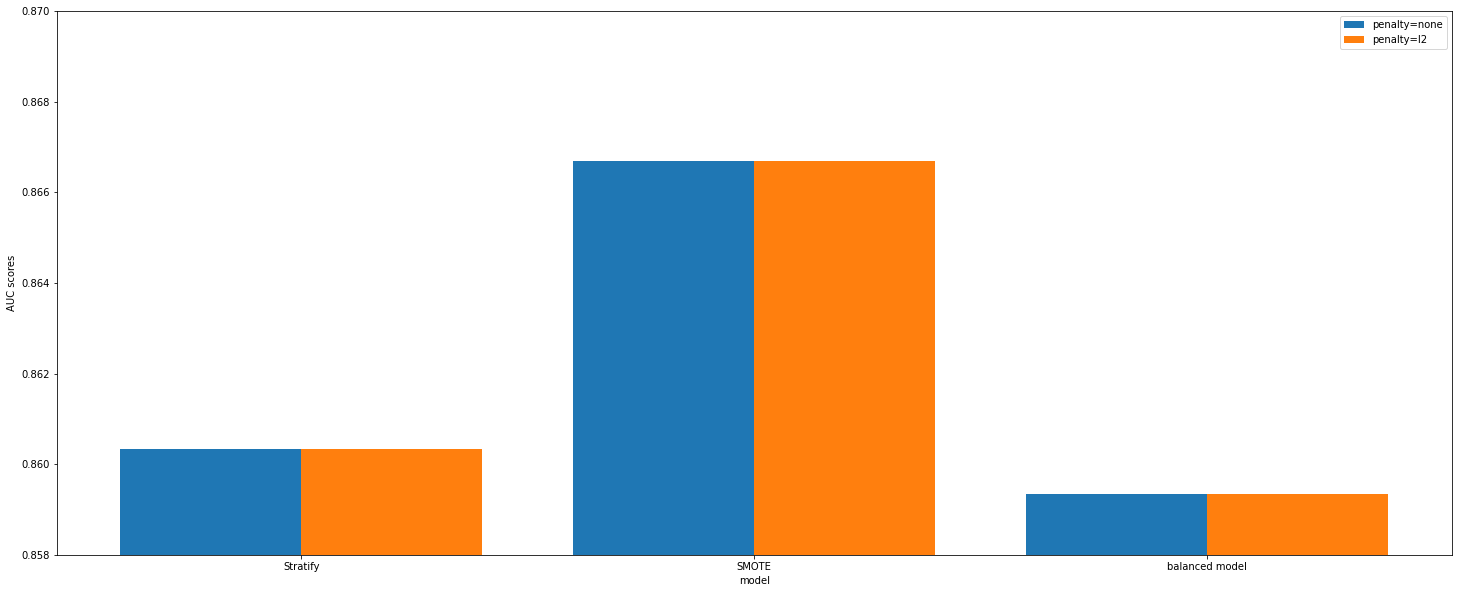

In [ ]:
none_l=[scores_stratify["test_roc_auc"].mean(),scores_smotesampled["test_roc_auc"].mean(),scores_balanced["test_roc_auc"].mean()]
l2_l=[scores_stratify_l2["test_roc_auc"].mean(),scores_smotesampled_l2["test_roc_auc"].mean(),scores_balanced_l2["test_roc_auc"].mean()]
fig = plt.figure(figsize = (25, 10))
x_axis = np.arange(3)
plt.bar(x_axis - 0.2, none_l, 0.4, label = 'penalty=none')
plt.bar(x_axis + 0.2, l2_l, 0.4, label = 'penalty=l2')
plt.xticks(x_axis, ["Stratify","SMOTE","balanced model"])
plt.xlabel("model")
plt.ylabel("AUC scores")
plt.ylim(0.858,0.87)
plt.legend()
plt.show()

## feature importance

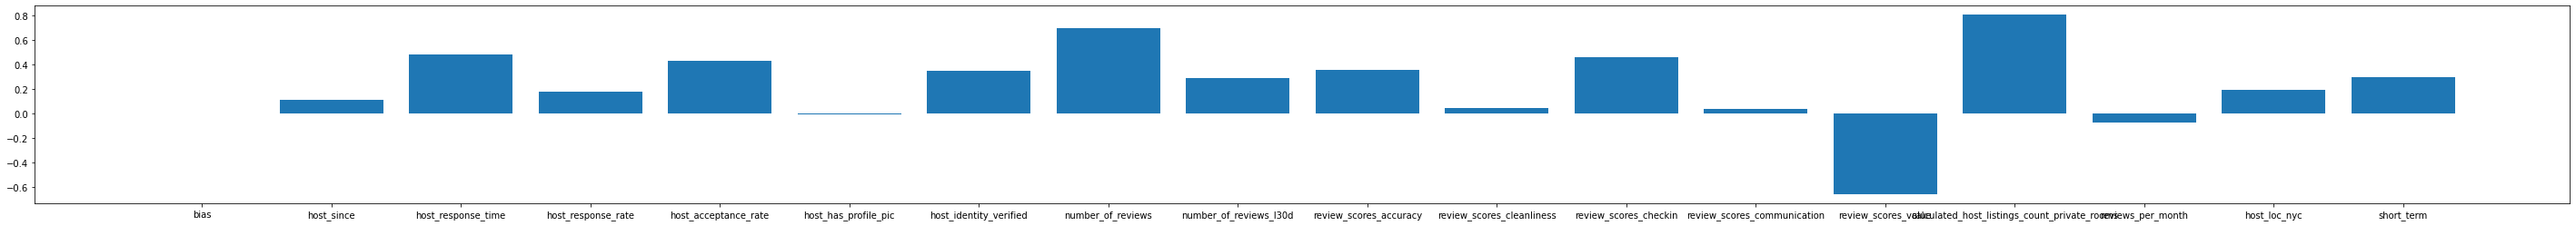

In [ ]:
importance = best_model_smotesampled.coef_[0]
# summarize feature importance
# plot feature importance
fig = plt.figure(figsize = (50, 4))
plt.bar([x for x in range(len(importance))], importance)
x=["bias"]+list(data.columns)
x_axis = np.arange(len(x))
plt.xticks(x_axis, x)
plt.show()

In [ ]:
feature_importance_sk = {}
for i, feature in enumerate(x):
    feature_importance_sk[feature] = importance[i]
print("top 3 most important features for this trained model:",sorted(feature_importance_sk,key=feature_importance_sk.get)[-3:])

top 3 most important features for this trained model: ['host_response_time', 'number_of_reviews', 'calculated_host_listings_count_private_rooms']


# 7. Decision Tree

In [ ]:
# baseline (using stratify sampling)
from sklearn import tree
from sklearn.model_selection import cross_validate
dt=tree.DecisionTreeClassifier(max_depth=10,random_state=42)
dt_stratify_score=cross_validate(dt,
                    X_train,
                    y_train,
                    cv=5,
                    scoring=['roc_auc','average_precision'],
                    return_estimator=True)
print("AUC:\n", dt_stratify_score['test_roc_auc'],"\nmean:",dt_stratify_score["test_roc_auc"].mean())
print("AP:\n", dt_stratify_score['test_average_precision'],"\nmean:",dt_stratify_score["test_average_precision"].mean())

AUC:
 [0.87987855 0.8797086  0.8853683  0.86768495 0.87527374] 
mean: 0.8775828300312707
AP:
 [0.6209444  0.63833805 0.65974278 0.63023129 0.61295904] 
mean: 0.6324431138019129


In [ ]:
def find_best_estimator(test1,test2):
    best_test1_i=np.argmax(test1)
    best_test2_i=np.argmax(test2)
    if best_test2_i==best_test1_i:
        return best_test2_i
    mean_test1=test1.mean()
    mean_test2=test2.mean()
    if max(test1)-test1.mean()>=max(test2)-test2.mean():
        return best_test1_i
    else:
        return best_test2_i

from sklearn.metrics import roc_auc_score,average_precision_score,balanced_accuracy_score
i=find_best_estimator(dt_stratify_score["test_roc_auc"],dt_stratify_score["test_average_precision"])
best_model_dt_stratify=dt_stratify_score['estimator'][i]
y_test_pred_dt_stratify=best_model_dt_stratify.predict(X_test)
auc_dt_stratify=roc_auc_score(y_test,y_test_pred_dt_stratify)
print("Decision Tree AUC with stratify sampling:", auc_dt_stratify)

Decision Tree AUC with stratify sampling: 0.7736023321642196


In [ ]:
#smote
dt=tree.DecisionTreeClassifier(max_depth=10,random_state=42)
dt_smote_score=cross_validate(dt,
                      X_dev_smote,
                      y_dev_smote,
                      cv=5,
                      scoring=["roc_auc","average_precision"],
                      return_estimator=True)
print("AUC:\n",dt_smote_score["test_roc_auc"],"\nmean:",dt_smote_score["test_roc_auc"].mean())
print("AP:\n",dt_smote_score["test_average_precision"],"\nmean:",dt_smote_score["test_average_precision"].mean())

AUC:
 [0.89388298 0.93275151 0.94272769 0.94668629 0.94499868] 
mean: 0.9322094283151978
AP:
 [0.87286677 0.91402461 0.92398466 0.92828501 0.92790475] 
mean: 0.9134131600749675


In [ ]:
i=find_best_estimator(dt_smote_score["test_roc_auc"],dt_smote_score["test_average_precision"])
best_model_dt_smote=dt_smote_score['estimator'][i]
y_test_pred_dt_smote=best_model_dt_smote.predict(X_test)
auc_dt_smote=roc_auc_score(y_test,y_test_pred_dt_smote)
print("Decision Tree AUC with smote resampling:" , auc_dt_smote)

Decision Tree AUC with smote resampling: 0.8101403376494214


In [ ]:
# balanced class weight
dt_cw=tree.DecisionTreeClassifier(max_depth=10,random_state=42, class_weight="balanced")
dt_cw_score=cross_validate(dt_cw,
                    X_dev,
                     y_dev,
                     cv=5,
                     scoring=["roc_auc","average_precision","accuracy"],
                     return_estimator=True)
print("AUC:\n",dt_cw_score["test_roc_auc"],"\nmean:",dt_cw_score["test_roc_auc"].mean())
print("AP:\n",dt_cw_score["test_average_precision"],"\nmean:",dt_cw_score["test_average_precision"].mean())


AUC:
 [0.89165619 0.88536546 0.889971   0.88454998 0.88924697] 
mean: 0.8881579178424988
AP:
 [0.66780761 0.653628   0.66680981 0.68429633 0.67637975] 
mean: 0.6697842998344312


In [ ]:
i=find_best_estimator(dt_cw_score["test_roc_auc"],dt_cw_score["test_average_precision"])
best_model_dt_cw=dt_cw_score['estimator'][i]
y_test_pred_dt_cw=best_model_dt_cw.predict(X_test)
auc_dt_cw=roc_auc_score(y_test,y_test_pred_dt_cw)
print("Decision Tree AUC with balanced class weight", auc_dt_cw)

Decision Tree AUC with balanced class weight 0.8110053155311203


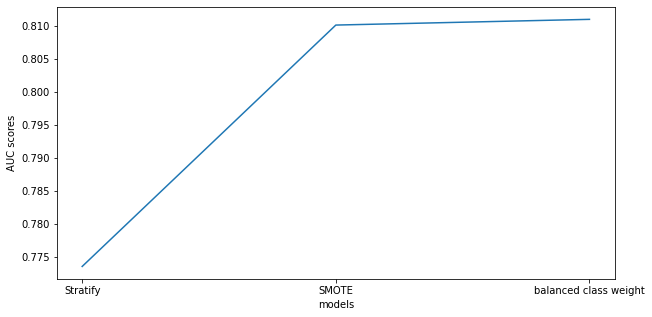

In [ ]:
# compare the scores
fig = plt.figure(figsize = (10, 5))
samplings=["Stratify","SMOTE","balanced class weight"]
scores = [auc_dt_stratify,auc_dt_smote,auc_dt_cw]
plt.plot(samplings, scores)
plt.xlabel('models')
plt.ylabel('AUC scores')
plt.show()

Since the Decision Tree Classifier with SMOTE gives the highest AUC score among the three, we plot the feature importance using the SMOTE model

17


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


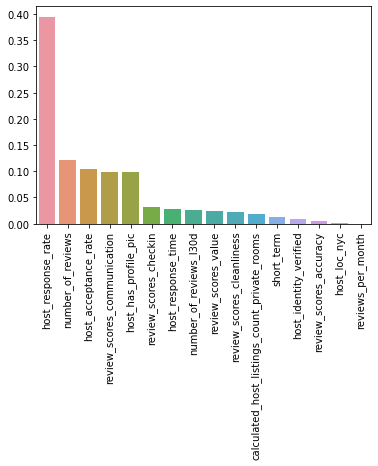

In [ ]:
# plot feature importance
import seaborn as sns
feature_names=data.columns.tolist()
print(len(feature_names))
feat_imps=zip(feature_names, best_model_dt_smote.feature_importances_)
feats,imps= zip(*(sorted(list(filter(lambda x:x[1]!=0,feat_imps)),key=lambda x:x[1],reverse=True)))

ax= sns.barplot(list(feats),list(imps))
ax.tick_params(axis='x',rotation=90)

As shown above, the top 3 features for Decision Tree Classifier are: "**host_response_rate**", "**num_of reviews**", "**host_acceptance_rate**"

# 8. Random Forest

In [ ]:
# baseline (using stratify sampling)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
rf=RandomForestClassifier()
rf_stratify_score=cross_validate(rf,
                    X_train,
                    y_train,
                    cv=5,
                    scoring=['roc_auc','average_precision'],
                    return_estimator=True)
print("AUC:\n", rf_stratify_score['test_roc_auc'],"\nmean:",rf_stratify_score["test_roc_auc"].mean())
print("AP:\n", rf_stratify_score['test_average_precision'],"\nmean:",rf_stratify_score["test_average_precision"].mean())

AUC:
 [0.93232806 0.94096584 0.93238534 0.92973257 0.92885443] 
mean: 0.9328532453718456
AP:
 [0.78188917 0.80717963 0.79341093 0.7775152  0.78145049] 
mean: 0.7882890827617921


In [ ]:
def find_best_estimator(test1,test2):
    best_test1_i=np.argmax(test1)
    best_test2_i=np.argmax(test2)
    if best_test2_i==best_test1_i:
        return best_test2_i
    mean_test1=test1.mean()
    mean_test2=test2.mean()
    if max(test1)-test1.mean()>=max(test2)-test2.mean():
        return best_test1_i
    else:
        return best_test2_i

from sklearn.metrics import roc_auc_score,average_precision_score,balanced_accuracy_score
i=find_best_estimator(rf_stratify_score["test_roc_auc"],rf_stratify_score["test_average_precision"])
best_model_rf_stratify=rf_stratify_score['estimator'][i]
y_test_pred_rf_stratify=best_model_rf_stratify.predict(X_test)
auc_rf_stratify=roc_auc_score(y_test,y_test_pred_rf_stratify)
print("Random Forest AUC using stratify sampling:", auc_rf_stratify)

Random Forest AUC using stratify sampling: 0.7830608579661333


In [ ]:
#smote
rf_smote_score=cross_validate(rf,
                      X_dev_smote,
                      y_dev_smote,
                      cv=5,
                      scoring=["roc_auc","average_precision"],
                      return_estimator=True)
print("AUC:\n",rf_smote_score["test_roc_auc"],"\nmean:",rf_smote_score["test_roc_auc"].mean())
print("AP:\n",rf_smote_score["test_average_precision"],"\nmean:",rf_smote_score["test_average_precision"].mean())

AUC:
 [0.95822812 0.97770376 0.98913343 0.98951757 0.99069378] 
mean: 0.9810553304043103
AP:
 [0.95191055 0.97570976 0.98662647 0.98777774 0.98973163] 
mean: 0.9783512313432008


In [ ]:
i=find_best_estimator(rf_smote_score["test_roc_auc"],rf_smote_score["test_average_precision"])
best_model_rf_smote=rf_smote_score['estimator'][i]
y_test_pred_rf_smote=best_model_rf_smote.predict(X_test)
auc_rf_smote=roc_auc_score(y_test,y_test_pred_rf_smote)
print("Random Forest AUC using smote resampling:" , auc_rf_smote)

Random Forest AUC using smote resampling: 0.8386612352510024


In [ ]:
# balanced class weight
rf_cw=RandomForestClassifier(class_weight="balanced")
rf_cw_score=cross_validate(rf_cw,
                    X_dev,
                     y_dev,
                     cv=5,
                     scoring=["roc_auc","average_precision","accuracy"],
                     return_estimator=True)
print("AUC:\n",rf_cw_score["test_roc_auc"],"\nmean:",rf_cw_score["test_roc_auc"].mean())
print("AP:\n",rf_cw_score["test_average_precision"],"\nmean:",rf_cw_score["test_average_precision"].mean())

AUC:
 [0.93937185 0.93449081 0.93202498 0.94013593 0.9332126 ] 
mean: 0.9358472338739432
AP:
 [0.80252462 0.7848066  0.78916    0.80843219 0.79726175] 
mean: 0.7964370332310633


In [ ]:
i=find_best_estimator(rf_cw_score["test_roc_auc"],rf_cw_score["test_average_precision"])
best_model_rf_cw=rf_cw_score['estimator'][i]
y_test_pred_rf_cw=best_model_rf_cw.predict(X_test)
auc_rf_cw=roc_auc_score(y_test,y_test_pred_rf_cw)
print("Decision Tree AUC using balanced class weight", auc_rf_cw)

Decision Tree AUC using balanced class weight 0.7767445635724515


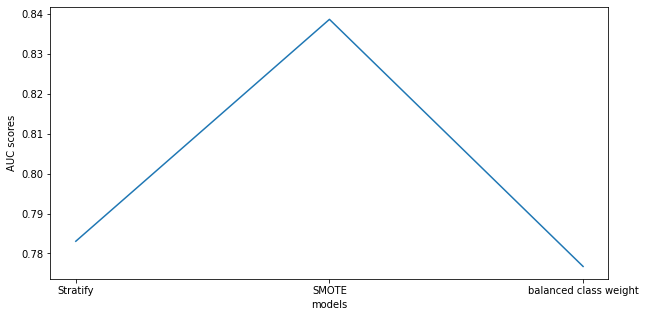

In [ ]:
# compare the scores
fig = plt.figure(figsize = (10, 5))
samplings=["Stratify","SMOTE","balanced class weight"]
scores = [auc_rf_stratify,auc_rf_smote,auc_rf_cw]
plt.plot(samplings, scores)
plt.xlabel('models')
plt.ylabel('AUC scores')
plt.show()

Since the SMOTE model gives the highest accuracy score, we plot the feature importance of this model

17


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


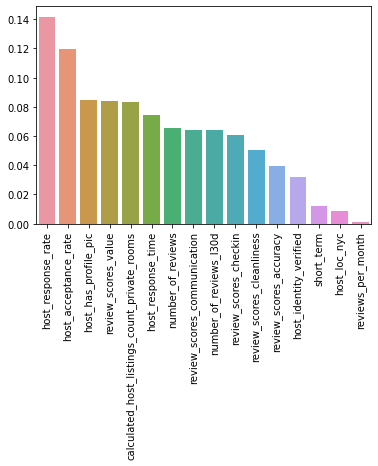

In [ ]:
# plot feature importance
import seaborn as sns
feature_names=data.columns.tolist()
print(len(feature_names))
feat_imps=zip(feature_names, best_model_rf_smote.feature_importances_)
feats,imps= zip(*(sorted(list(filter(lambda x:x[1]!=0,feat_imps)),key=lambda x:x[1],reverse=True)))

ax= sns.barplot(list(feats),list(imps))
ax.tick_params(axis='x',rotation=90)

As shown above, the top 3 features of the random forest model are: "**host_response_rate**", "**host_acceptance_rate**", "**host_has_profile_pic**"

# 9. Gradient Boosting Trees

In [ ]:
# baseline (using stratify sampling)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
gbc=GradientBoostingClassifier()
gbc_stratify_score=cross_validate(gbc,
                    X_train,
                    y_train,
                    cv=5,
                    scoring=['roc_auc','average_precision'],
                    return_estimator=True)
print("AUC:\n", gbc_stratify_score['test_roc_auc'],"\nmean:",gbc_stratify_score["test_roc_auc"].mean())
print("AP:\n", gbc_stratify_score['test_average_precision'],"\nmean:",gbc_stratify_score["test_average_precision"].mean())

AUC:
 [0.92180575 0.92871559 0.91978038 0.91639578 0.91827705] 
mean: 0.92099490777993
AP:
 [0.76699181 0.7935591  0.76987308 0.76164032 0.76007428] 
mean: 0.77042771922353


In [ ]:
def find_best_estimator(test1,test2):
    best_test1_i=np.argmax(test1)
    best_test2_i=np.argmax(test2)
    if best_test2_i==best_test1_i:
        return best_test2_i
    mean_test1=test1.mean()
    mean_test2=test2.mean()
    if max(test1)-test1.mean()>=max(test2)-test2.mean():
        return best_test1_i
    else:
        return best_test2_i

from sklearn.metrics import roc_auc_score,average_precision_score,balanced_accuracy_score
i=find_best_estimator(gbc_stratify_score["test_roc_auc"],gbc_stratify_score["test_average_precision"])
best_model_gbc_stratify=gbc_stratify_score['estimator'][i]
y_test_pred_gbc_stratify=best_model_gbc_stratify.predict(X_test)
auc_gbc_stratify=roc_auc_score(y_test,y_test_pred_gbc_stratify)
print("Gradient Boosting AUC using stratify sampling:", auc_gbc_stratify)

Gradient Boosting AUC using stratify sampling: 0.7727636116664931


In [ ]:
#smote
gbc_smote_score=cross_validate(gbc,
                      X_dev_smote,
                      y_dev_smote,
                      cv=5,
                      scoring=["roc_auc","average_precision"],
                      return_estimator=True)
print("AUC:\n",gbc_smote_score["test_roc_auc"],"\nmean:",gbc_smote_score["test_roc_auc"].mean())
print("AP:\n",gbc_smote_score["test_average_precision"],"\nmean:",gbc_smote_score["test_average_precision"].mean())

AUC:
 [0.91838501 0.95377299 0.9690203  0.97160246 0.9699731 ] 
mean: 0.9565507739000498
AP:
 [0.90888052 0.95310716 0.96884437 0.97217231 0.9706114 ] 
mean: 0.9547231541807424


In [ ]:
i=find_best_estimator(gbc_smote_score["test_roc_auc"],gbc_smote_score["test_average_precision"])
best_model_gbc_smote=gbc_smote_score['estimator'][i]
y_test_pred_gbc_smote=best_model_gbc_smote.predict(X_test)
auc_gbc_smote=roc_auc_score(y_test,y_test_pred_gbc_smote)
print("Gradient Boosting AUC with smote resampling:" , auc_gbc_smote)

Gradient Boosting AUC with smote resampling: 0.8225989040353737


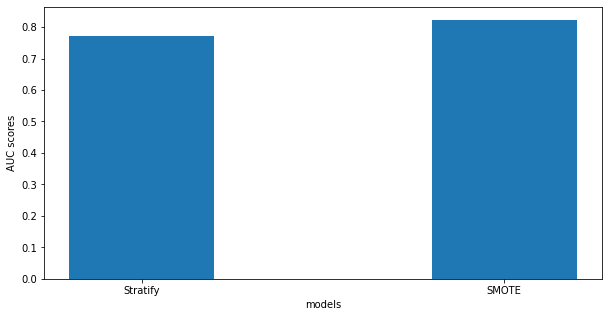

In [ ]:
# compare the scores
fig = plt.figure(figsize = (10, 5))
samplings=["Stratify","SMOTE"]
scores = [auc_gbc_stratify,auc_gbc_smote]
plt.bar(samplings, scores, width = 0.4)
plt.xlabel('models')
plt.ylabel('AUC scores')
plt.show()

Since SMOTE has greater AUC score than the baseline model, we plot the feature importance of the SMOTE model

17


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


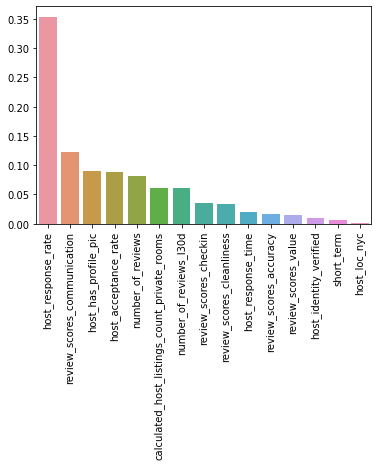

In [ ]:
# plot feature importance
import seaborn as sns
feature_names=data.columns.tolist()
print(len(feature_names))
feat_imps=zip(feature_names, best_model_gbc_smote.feature_importances_)
feats,imps= zip(*(sorted(list(filter(lambda x:x[1]!=0,feat_imps)),key=lambda x:x[1],reverse=True)))

ax= sns.barplot(list(feats),list(imps))
ax.tick_params(axis='x',rotation=90)

As shown above, the top 3 features of the Gradient Boosting Tree model using SMOTE resampling are: "**host_response_rate**", "**review_scores_communicatio**n", "**host_has_profile_pic**"

# 10. XGBoost

In [ ]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# baseline (using stratify sampling)
import xgboost as xgb
from sklearn.model_selection import cross_validate
xgbmodel=xgb.XGBClassifier()
xgb_stratify_score=cross_validate(xgbmodel,
                    X_train,
                    y_train,
                    cv=5,
                    scoring=['roc_auc','average_precision'],
                    return_estimator=True)
print("AUC:\n", xgb_stratify_score['test_roc_auc'],"\nmean:",xgb_stratify_score["test_roc_auc"].mean())
print("AP:\n", xgb_stratify_score['test_average_precision'],"\nmean:",xgb_stratify_score["test_average_precision"].mean())

AUC:
 [0.92039421 0.92814569 0.91759317 0.91546438 0.91717312] 
mean: 0.91975411430684
AP:
 [0.7594931  0.78772215 0.76185938 0.75691873 0.75446755] 
mean: 0.7640921841402158


In [ ]:
def find_best_estimator(test1,test2):
    best_test1_i=np.argmax(test1)
    best_test2_i=np.argmax(test2)
    if best_test2_i==best_test1_i:
        return best_test2_i
    mean_test1=test1.mean()
    mean_test2=test2.mean()
    if max(test1)-test1.mean()>=max(test2)-test2.mean():
        return best_test1_i
    else:
        return best_test2_i

from sklearn.metrics import roc_auc_score,average_precision_score,balanced_accuracy_score
i=find_best_estimator(xgb_stratify_score["test_roc_auc"],xgb_stratify_score["test_average_precision"])
best_model_xgb_stratify=xgb_stratify_score['estimator'][i]
y_test_pred_xgb_stratify=best_model_xgb_stratify.predict(X_test)
auc_xgb_stratify=roc_auc_score(y_test,y_test_pred_xgb_stratify)
print("XGBoost AUC with stratify sampling:", auc_xgb_stratify)

XGBoost AUC with stratify sampling: 0.7699541693743066


In [ ]:
#smote
xgb_smote_score=cross_validate(xgbmodel,
                      X_dev_smote,
                      y_dev_smote,
                      cv=5,
                      scoring=["roc_auc","average_precision"],
                      return_estimator=True)
print("AUC:\n",xgb_smote_score["test_roc_auc"],"\nmean:",xgb_smote_score["test_roc_auc"].mean())
print("AP:\n",xgb_smote_score["test_average_precision"],"\nmean:",xgb_smote_score["test_average_precision"].mean())

AUC:
 [0.91729127 0.95355215 0.96672014 0.96806725 0.96768004] 
mean: 0.9546621694960093
AP:
 [0.90684811 0.9530798  0.96681135 0.96844202 0.96822299] 
mean: 0.9526808534771238


In [ ]:
i=find_best_estimator(xgb_smote_score["test_roc_auc"],xgb_smote_score["test_average_precision"])
best_model_xgb_smote=gbc_smote_score['estimator'][i]
y_test_pred_xgb_smote=best_model_xgb_smote.predict(X_test)
auc_xgb_smote=roc_auc_score(y_test,y_test_pred_xgb_smote)
print("XGBoost AUC with SMOTE:" , auc_xgb_smote)

XGBoost AUC with SMOTE: 0.8225989040353737


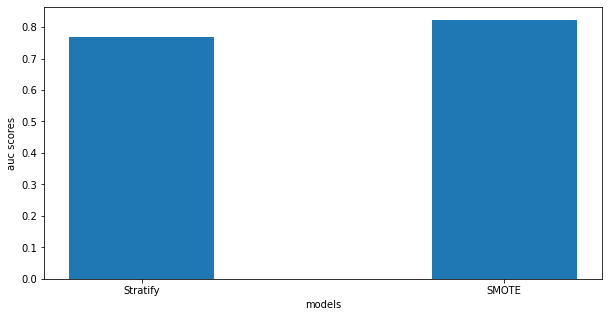

In [ ]:
# compare the scores
fig = plt.figure(figsize = (10, 5))
samplings=["Stratify","SMOTE"]
scores = [auc_xgb_stratify,auc_xgb_smote]
plt.bar(samplings, scores, width = 0.4)
plt.xlabel('models')
plt.ylabel('auc scores')
plt.show()

Since SMOTE has greater accuracy score than the baseline model, we plot the feature importance using the SMOTE model

17


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


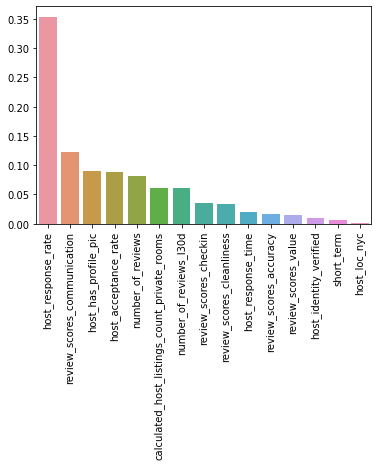

In [ ]:
# plot feature importance
import seaborn as sns
feature_names=data.columns.tolist()
print(len(feature_names))
feat_imps=zip(feature_names, best_model_xgb_smote.feature_importances_)
feats,imps= zip(*(sorted(list(filter(lambda x:x[1]!=0,feat_imps)),key=lambda x:x[1],reverse=True)))

ax= sns.barplot(list(feats),list(imps))
ax.tick_params(axis='x',rotation=90)

As shown above, the top 3 features of the XGBoost model using SMOTE resampling are: "**host_response_rate**", "**review_scores_communication**", **"host_has_profile_pic**"

# 11. Visualize result

[('Logistic Regression', 0.766), ('Decision Trees', 0.81), ('Random Forest', 0.839), ('Gradient Boosting', 0.823), ('XGBoost', 0.823)]


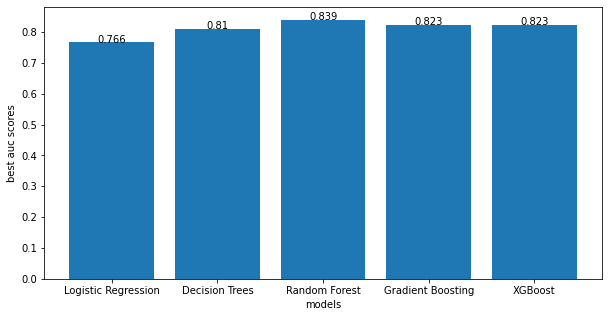

In [ ]:
best_auc = [round(auc_smotesampled,3), round(auc_dt_smote,3), round(auc_rf_smote,3), round(auc_gbc_smote,3), round(auc_xgb_smote,3) ]
models = ['Logistic Regression','Decision Trees','Random Forest','Gradient Boosting','XGBoost']
result = zip(models,best_auc)
print(list(result))

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

fig = plt.figure(figsize = (10, 5))
plt.bar(models, best_auc)
plt.xlabel('models')
plt.ylabel('best auc scores')
addlabels(models, best_auc)
plt.show()